# Contents

      Training
           - Imports
           - Mounting Drive
           - Getting paths and directories, setting global variables
           - Pre-processing and Data Augmentation
           - Previewing Data Augmentation
           - Functions to calculate metrics
           - Model build using transfer learning architecture.
           - Function to graph model metrics
           - Train and Save Model
           - Training and Validation Metrics
      Testing
          - Make Predictions
          - Visualize Predictions
          - Evaluate Model
          - In-Depth Metrics Report 
          - Confusion Matrix
          - ROC Curve
          - Precision-Recall Curve
          - Compare Metrics at Different Classification Thresholds
          - Optimal Cutoffs
      
    

**Imports**

In [ ]:
import os, shutil, PIL, keras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import random
import numpy as np
import cv2

from pathlib import Path
from keras import layers, models, optimizers, regularizers

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetMobile
from keras.applications import InceptionResNetV2
from keras.applications import InceptionV3
from keras.models import Model, Input, Sequential,load_model
from keras.layers import AveragePooling2D, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn import metrics

import matplotlib.image as mpimg

import itertools
from sklearn import metrics

import sklearn.metrics
import math
import pandas as pd


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

**Getting paths and directories, setting global variables**

In [ ]:
IMAGE_SIZE = (224, 224)
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 64
NUM_EPOCHS = 50
TRANSFER_MODEL = InceptionV3(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3), include_top=False)
#percent of layers that will be trainable from original model
PERCENT_TRAINABLE = 0.5


TRAIN_DIR = '/content/drive/My Drive/CVT/data/train'
VAL_DIR = '/content/drive/My Drive/CVT/data/validation'
TEST_DIR = '/content/drive/My Drive/CVT/data/test'
#hold-out set
TEST2_DIR = '/content/drive/My Drive/CVT/HO-data'

NUM_TRAIN_SAMPLES = len(os.listdir(TRAIN_DIR + "/COVID")) + len(os.listdir(TRAIN_DIR + "/NonCOVID"))
NUM_VAL_SAMPLES = len(os.listdir(VAL_DIR + "/COVID")) + len(os.listdir(VAL_DIR + "/NonCOVID"))


87916544/87910968 [==============================] - 1s 0us/step


**Pre-processing and Data Augmentation**

In [ ]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.5, 1.0],
        shear_range=0.05,
        zoom_range=0.15,
        horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode="constant",
        # cval=255
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        shuffle=False,
        class_mode='binary'
    )

    train_generator = train_datagen.flow_from_directory(
          TRAIN_DIR,
          target_size=IMAGE_SIZE,
          batch_size=TRAIN_BATCH_SIZE,
          class_mode='binary'
       )

    validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='binary'
    )
    
    test_generator2 = test_datagen.flow_from_directory(
        TEST2_DIR,
        target_size=IMAGE_SIZE,
        shuffle=False,
        class_mode='binary'
    )

    return (train_generator, validation_generator, test_generator, test_generator2)

def add_noise_contrast(img):
    VARIABILITY = 25
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def augment(img):
    if np.random.random() < 0.3:
      kernel = np.ones((5, 5), np.uint8)
      img = cv2.erode(img, kernel, iterations=1)
    if np.random.random() < 0.3:
      kernel = np.ones((5, 5), np.uint8)
      img = cv2.dilate(img, kernel, iterations=1) 
    # return add_noise_contrast(img)
    return img




**Previewing Data Augmentation**

/content/drive/My Drive/CVT/data/train/NonCOVID/Non-Covid (786).png
(1, 224, 224, 3)


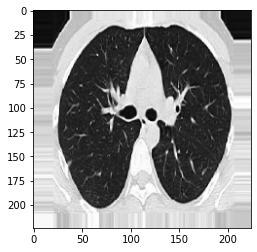

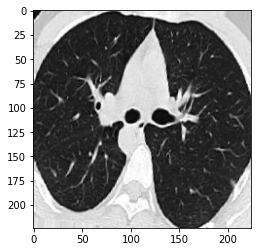

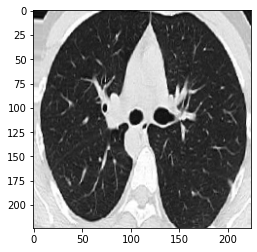

/content/drive/My Drive/CVT/data/train/NonCOVID/Non-Covid (290).png
(1, 224, 224, 3)


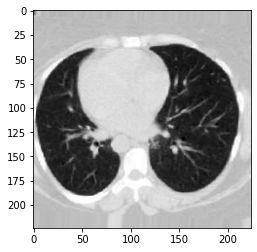

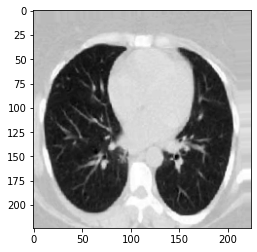

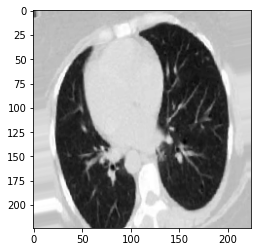

/content/drive/My Drive/CVT/data/train/NonCOVID/Non-Covid (622).png
(1, 224, 224, 3)


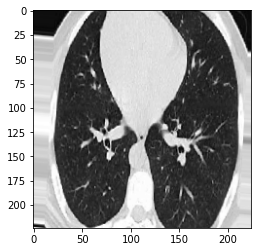

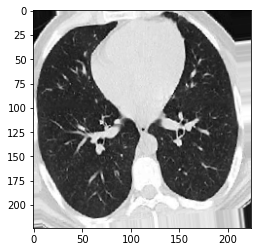

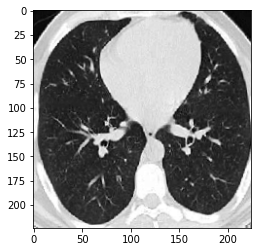

In [ ]:
def test_augmentation():
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.04,
        height_shift_range=0.04,
        brightness_range=[0.4, 1.0],
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode="constant",
        # cval=255

    )
  
    fnames_covid = [os.path.join(TRAIN_DIR, 'COVID', fname) for fname in os.listdir(os.path.join(TRAIN_DIR, 'COVID'))]
    fnames_noncovid = [os.path.join(TRAIN_DIR, 'NonCOVID', fname) for fname in os.listdir(os.path.join(TRAIN_DIR, 'NonCOVID'))]
    fnames = fnames_covid + fnames_noncovid
    for r in range(3):
      img_path = fnames[random.randint(0, len(fnames) - 1)]
      print(img_path)

      img = image.load_img(img_path, target_size=IMAGE_SIZE)
      x = image.img_to_array(img)
      x = x.reshape((1,) + x.shape)
      print(x.shape)
      i = 0
      for batch in datagen.flow(x, batch_size=1):
          plt.figure(i)
          imgplot = plt.imshow(image.array_to_img(batch[0]))
          i += 1
          if (i % 3 == 0):
            break
      plt.show()

test_augmentation()

**Functions to calculate metrics**



In [ ]:
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def f2(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f2_val = (5 * precision * recall) / (4 * precision + recall+K.epsilon())
    return f2_val


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred))/2

**Model build using transfer learning architecture.**

In [ ]:
def build_transfer():
  IMG_SHAPE = (224, 224, 3)

  for index,layer in enumerate(TRANSFER_MODEL.layers):
    if index < len(TRANSFER_MODEL.layers) * PERCENT_TRAINABLE: 
      layer.trainable = False 
    else:
      layer.trainable = True 
      

  X = layers.Flatten()(TRANSFER_MODEL.output)    
  X = layers.Dense(64)(X)
  X = layers.Activation('relu')(X)
  X = layers.Dropout(0.5)(X)                   
  X = layers.Dense (1, activation='sigmoid')(X)           

  model = Model(TRANSFER_MODEL.input, X) 

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(threshold=0.5),
                       balanced_acc, 
                       f1, 
                       f2,
                       tf.keras.metrics.Recall(name="recall"), 
                       specificity,
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.AUC(name="auc")])
  return model

**Function to graph model metrics**

In [ ]:
def graph_metrics(history):
  metrics_list = list(history.history.keys())
  num_metrics = int(len(metrics_list)/2)

  fig, axs = plt.subplots(math.ceil(num_metrics/2), 2, figsize=(20, 35))

  epochs = range(1, NUM_EPOCHS+1)

  for i in range(num_metrics-1):
    train_metric = history.history[metrics_list[i]]
    val_metric = history.history[metrics_list[i + num_metrics]]
    row = int(i/2)
    col = 1 * (i % 2 != 0)
    axs[row, col].plot(epochs, train_metric, label='Training ' + metrics_list[i])
    axs[row, col].plot(epochs, val_metric, label='Validation' + metrics_list[i])
    axs[row, col].set_title(metrics_list[i])
    axs[row, col].legend()
  plt.show()

**Train and Save Model**

In [ ]:
def train(model, train_generator, validation_generator):
    history = model.fit(
                    train_generator,
                    steps_per_epoch=NUM_TRAIN_SAMPLES//TRAIN_BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_SAMPLES//VAL_BATCH_SIZE,
                    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=5)]
            )
    return history

In [ ]:
model = build_transfer()
train_generator, validation_generator, test_generator, test2_generator = preprocess_data()
history = train(model, train_generator, validation_generator)
%cd /content/My\ Drive/CVT
model.save("saved_models/inceptionv3")


Found 690 images belonging to 2 classes.
Found 3217 images belonging to 2 classes.
Found 690 images belonging to 2 classes.
Found 361 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 191s 2s/step - loss: 0.7236 - binary_accuracy: 0.5639 - balanced_acc: 0.5491 - f1: 0.3798 - f2: 0.3396 - recall: 0.3262 - specificity: 0.7721 - precision: 0.5634 - auc: 0.5948 - val_loss: 0.9571 - val_binary_accuracy: 0.5938 - val_balanced_acc: 0.5684 - val_f1: 0.2425 - val_f2: 0.1682 - val_recall: 0.1424 - val_specificity: 0.9971 - val_precision: 0.9773 - val_auc: 0.7633
Epoch 2/50
100/100 [==============================] - 62s 619ms/step - loss: 0.6354 - binary_accuracy: 0.6998 - balanced_acc: 0.6958 - f1: 0.6016 - f2: 0.5530 - recall: 0.5240 - specificity: 0.8625 - precision: 0.7656 - auc: 0.7437 - val_loss: 0.5591 - val_binary_accuracy: 0.7703 - val_balanced_acc: 0.7678 - val_f1: 0.7547 - val_f2: 0.7576 - val_recall: 0.7616 - val_specificity: 0.7754 - val_precision: 

**Training and Validation Metrics**

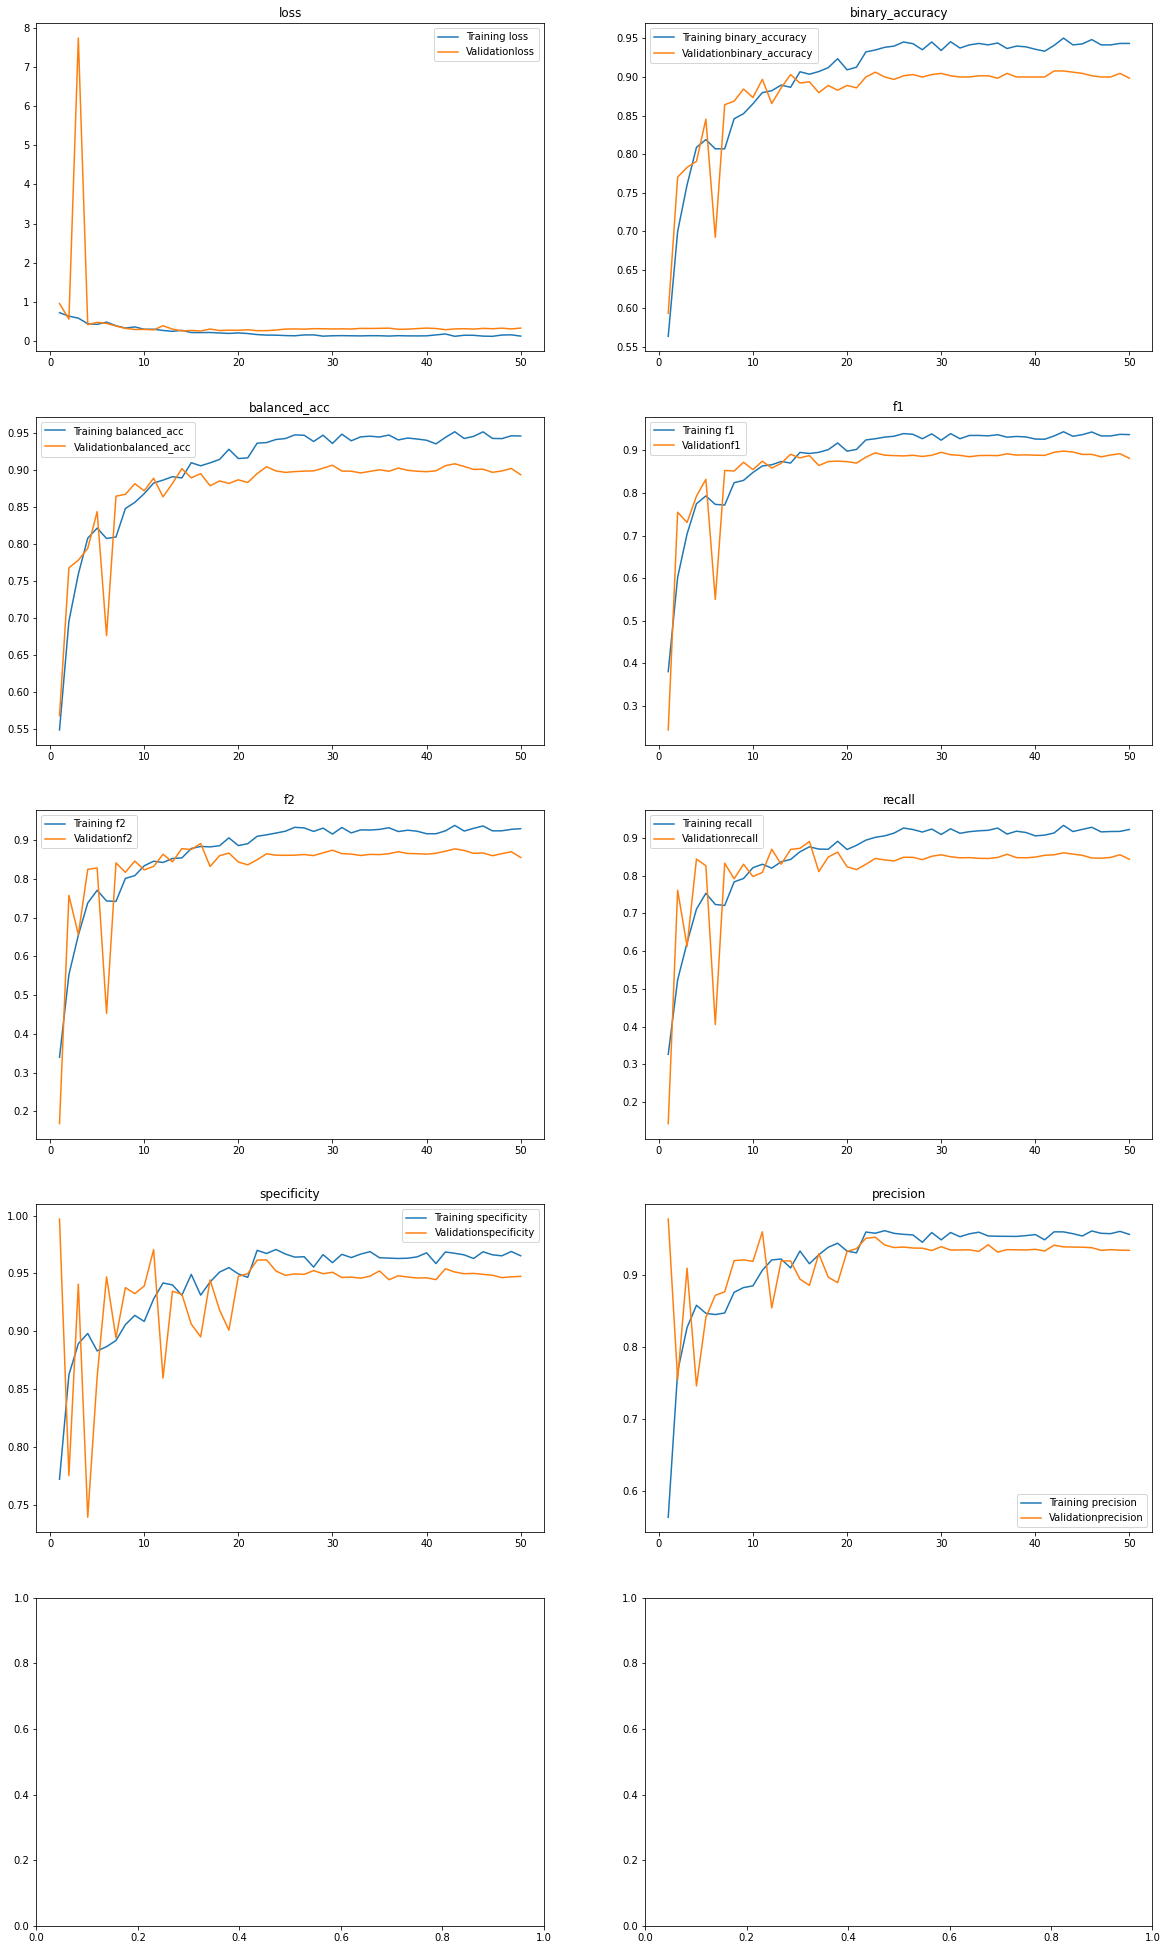

In [ ]:
graph_metrics(history)

**Make Predictions**

In [ ]:
# test_generator = test2_generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        shuffle=False,
        class_mode='binary'
    )
y_true = 1 - test_generator.classes
prediction = (1 - model.predict(test_generator))
y_pred = [1 * (x[0]>=.35) for x in prediction]

Found 690 images belonging to 2 classes.


**Visualize Predictions**

prob:[0.99999976]
COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png


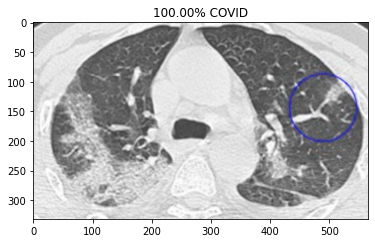

prob:[0.3027358]
COVID/Covid (1206).png


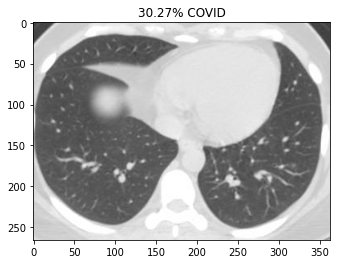

prob:[0.9999998]
COVID/Covid (580).png


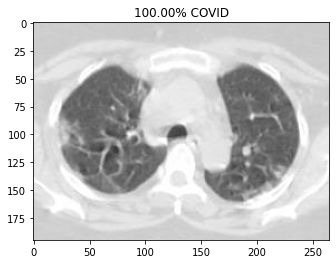

prob:[0.99979764]
COVID/img460.jpg


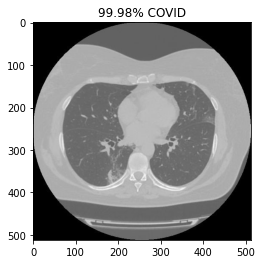

prob:[0.00035524]
NonCOVID/Non-Covid (106).png


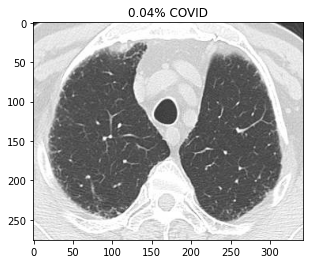

prob:[0.00184947]
NonCOVID/Non-Covid (52).png


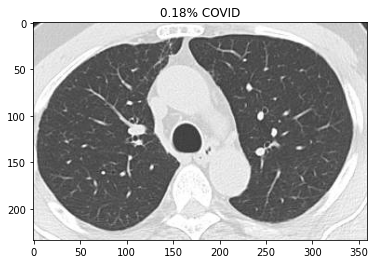

prob:[0.00981027]
NonCOVID/Non-Covid (906).png


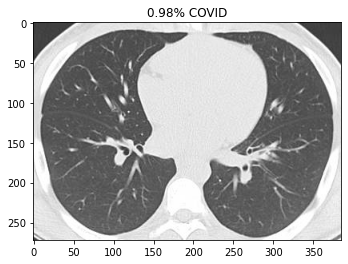

In [ ]:
index = 0
while index < len(prediction):
  probability = prediction[index]
  image_path =  TEST_DIR + "/" +test_generator.filenames[index]
  image = mpimg.imread(image_path, 0)
  #BGR TO RGB conversion using CV2
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  pixels = np.array(image)
  plt.imshow(pixels)
  print("prob:{}".format(probability))
  print(test_generator.filenames[index])
    
  plt.title('%.2f' % ((probability)*100) + '% COVID')
  plt.show()
  index+=random.randint(50,150)


**Evaluate Model**

In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       325
           1       0.86      0.96      0.91       365

    accuracy                           0.90       690
   macro avg       0.90      0.89      0.89       690
weighted avg       0.90      0.90      0.89       690



**In-Depth Metrics Report**
see https://en.wikipedia.org/wiki/Confusion_matrix

In [ ]:
def matrix_metrix(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true , y_pred)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,3)
    Accuracy   = round( (TP+TN) / Population,3)
    Precision  = round( TP / (TP+FP),3 )
    NPV        = round( TN / (TN+FN),3 )
    FDR        = round( FP / (TP+FP),3 )
    FOR        = round( FN / (TN+FN),3 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),3 )
    FPR        = round( FP / (TN+FP),3 )
    Specificity = 1 - FPR
    FNR        = round( FN / (TP+FN),3)
    TNR        = round( TN / (TN+FP),3 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,3 ) 
    LRNeg      = round( FNR / TNR ,3 )
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    F2      = round ( (1+2**2)*((Precision*Recall)/((2**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1
    AUC = round(roc_auc_score(y_true, y_pred),3)

    met_dict = {
   'TP': TP,'TN':TN,'FP':FP,  'FN':FN,   'Prevalence':Prevalence, 
     'Accuracy':Accuracy,   'Precision':Precision,'Recall':Recall,
    'F1':F1,  'F2':F2, 'AUC':AUC, 'NPV':NPV,'FPR':FPR,
   'TNR':Specificity,  'FNR':FNR, 'TNR':TNR,'FDR':FDR,'FOR':FOR,'check_Pos':check_Pos,
   'check_Neg':check_Neg,  'check_Pos2':check_Pos2, 'check_Neg2':check_Neg2, 'LR+':LRPos,
    'LR-':LRNeg,  'DOR':DOR, 'MCC':MCC,'BM':BM,'MK':MK 
   }  

    return met_dict

for key, value in matrix_metrix(y_true, y_pred).items(): 
    print("{:<10} {:<10}".format(key, value)) 

TP         351       
TN         267       
FP         58        
FN         14        
Prevalence 0.593     
Accuracy   0.896     
Precision  0.858     
Recall     0.962     
F1         0.907     
F2         0.9392    
AUC        0.892     
NPV        0.95      
FPR        0.178     
TNR        0.822     
FNR        0.038     
FDR        0.142     
FOR        0.05      
check_Pos  1.0       
check_Neg  1.0       
check_Pos2 1.0       
check_Neg2 1.0       
LR+        5.404     
LR-        0.046     
DOR        117.0     
MCC        0.7957    
BM         0.7839999999999998
MK         0.8079999999999998


**Confusion Matrix**

Confusion matrix, without normalization


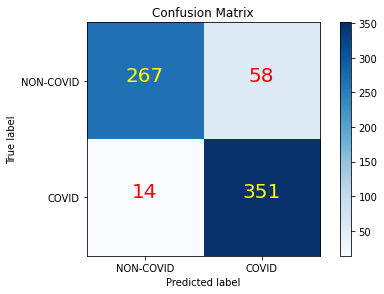

Normalized confusion matrix


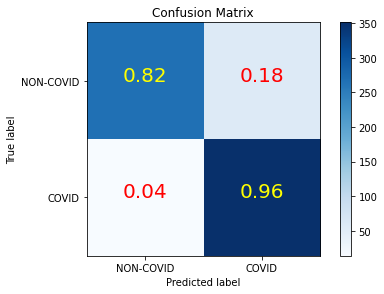

In [ ]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize= 20,
                 horizontalalignment="center",
                 color="yellow" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
cm=metrics.confusion_matrix(y_true,y_pred)
plot_confusion_matrix(cm=cm, classes=['NON-COVID', 'COVID'], title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=['NON-COVID', 'COVID'], title='Confusion Matrix', normalize=True)

**ROC Curve**

AUC: 0.9638356164383561


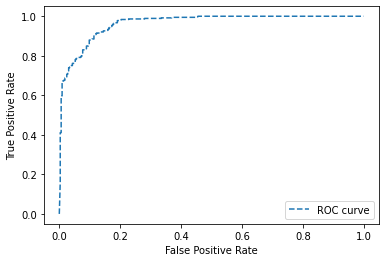

In [ ]:
#ROC Implementation
def get_roc_curve(y_true, y_pred):
  print("AUC: " + str(metrics.roc_auc_score(y_true, y_pred)))
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  # print(fpr)
  # print(tpr)
  pyplot.plot(fpr, tpr, linestyle='--', label='ROC curve')
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.legend()
  pyplot.show()
  
get_roc_curve(y_true, prediction)



**Precision-Recall Curve**

Average Precision: 0.9627389208029925


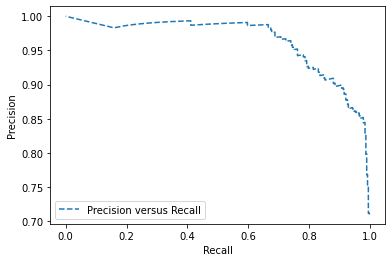

In [ ]:
def get_pr_curve(y_true, y_pred):
  print("Average Precision: " +  str(sklearn.metrics.average_precision_score(y_true, y_pred)))
  precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_pred)
  pyplot.plot(recall, precision, linestyle='--', label='Precision versus Recall')
  pyplot.xlabel('Recall')
  pyplot.ylabel('Precision')
  pyplot.legend()
  pyplot.show()

get_pr_curve(y_true, prediction)

**Compare Metrics at Different Classification Thresholds**

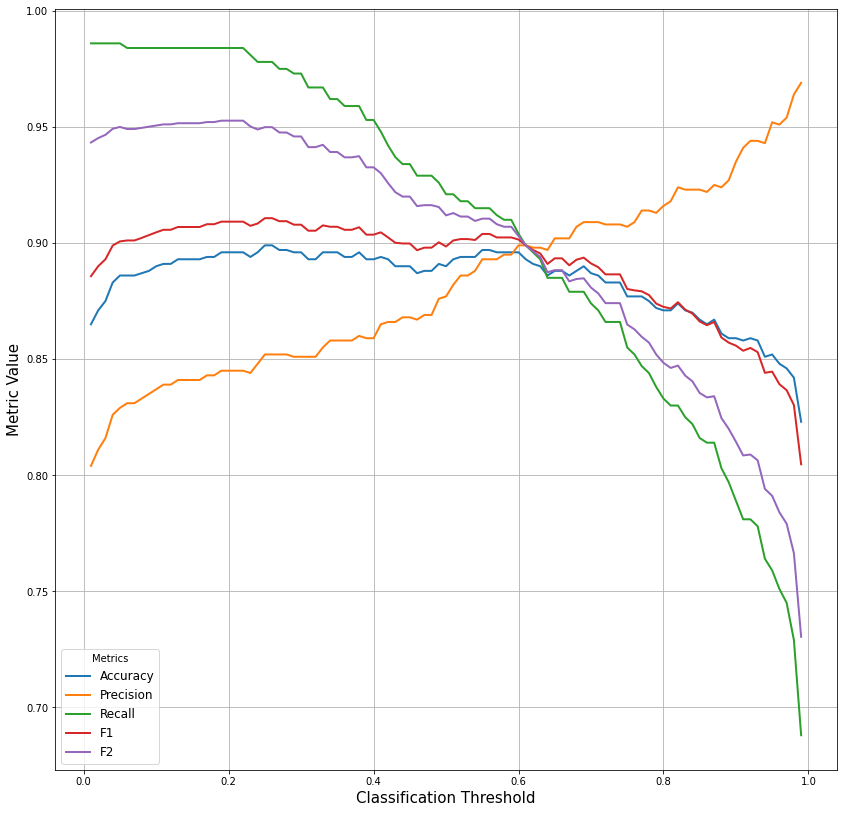

In [ ]:
thresholds = [round(i * .01, 2) for i in range(1,100)]
def metric_against_thresholds(metric):
    vals = []
    for t in thresholds:
      y_pred = [1 * (x>=t) for x in prediction]
    
      vals.append(float(matrix_metrix(y_true, y_pred)[metric]))

    return vals

def plot_metrics_against_thresholds(desired_metrics= ["Accuracy","Precision", "Recall", "F1", "F2"]):
  pyplot.figure(figsize=(14,14))
  pyplot.xlabel("Classification Threshold", fontsize=15)
  pyplot.ylabel("Metric Value", fontsize=15)
  for i in range(len(desired_metrics)):
    pyplot.plot(thresholds, metric_against_thresholds(desired_metrics[i]), lw=2, label=desired_metrics[i])
  pyplot.legend(title="Metrics", fontsize='large')
  pyplot.grid()
  pyplot.show()
plot_metrics_against_thresholds()

**Optimal Cutoffs**

see https://www.hindawi.com/journals/cmmm/2017/3762651/

In [ ]:
def get_optimal_cutoffs():
  TN, FP, FN, TP = metrics.confusion_matrix(y_true,y_pred).ravel()
  sensitivity = round( TP / (TP+FN),2 )
  specificity = round( TN / (TN+FP),2 )
  auc = metrics.roc_auc_score(y_true, y_pred)

  youden = sensitivity + specificity - 1
  print("youden: " + str(youden))

  closest_to_01 =  np.sqrt(((1 - sensitivity)**2) + ((1 - specificity)**2))
  print("Closest to (0,1): " + str(np.around(closest_to_01, decimals = 3)))

  concordance_probability = sensitivity * specificity
  print("Concordance Probability: " + str((np.around(concordance_probability, decimals = 3))))

  index_of_union = np.abs(sensitivity - auc) + np.abs(specificity - auc)
  print("Index of Union: " + str((np.around(index_of_union, decimals = 3))))

get_optimal_cutoffs()


youden: 0.7799999999999998
Closest to (0,1): 0.184
Concordance Probability: 0.787
Index of Union: 0.14
